**Import statements**


In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import PassiveAggressiveRegressor

%matplotlib inline

**Constants**

In [2]:
dates = ["20180703-20180704",
         "20180704-20180705", 
         "20180705-20180706", 
         "20180706-20180707"]

sensors = ["02E5F77764B873DA", 
           "200A7CED9D597407", 
           "AA0E63CF5118F98F", 
           "B61241EF668DBC2C", 
           "E5FD8C55EAA37555", 
           "E786F1568F65C296"]

finalStaticCoords = { "E5FD8C55EAA37555" : [55.9454333, -3.1913917],  # Lauriston
                      "02E5F77764B873DA" : [55.9397722,-3.1915444],   # Melville
                      "200A7CED9D597407" : [55.9430028,-3.1921472],   # Library 
                      "AA0E63CF5118F98F" : [55.940953, -3.186092],    # Tennis court
                      "B61241EF668DBC2C" : [55.945302, -3.188279],    # Bristo Square
                      "E786F1568F65C296" : [55.943014, -3.185994]}    # Buccleuch Place

gridStaticCoords = { "E5FD8C55EAA37555" : [4, 6],   # Lauriston
                     "02E5F77764B873DA" : [17, 6],  # Melville
                     "200A7CED9D597407" : [9, 5],   # Library 
                     "AA0E63CF5118F98F" : [14, 13], # Tennis court
                     "B61241EF668DBC2C" : [4, 10],  # Bristo Square
                     "E786F1568F65C296" : [9, 13]}  # Buccleuch Place
columns_needed = ['Timestamp','PM1', 'PM2.5', 'PM10', 'temperature', 'humidity', 'lat', 'long']


**Load Data**

In [3]:
static_sensor_data=[]
for sensor in sensors:
    list_ = []
    for date in dates:
        filename = "data/raw/static/{}/{}.csv".format(date, sensor)
        df = pd.read_csv(filename,index_col=None)
        df['lat'] = finalStaticCoords[sensor][0]
        df['long'] = finalStaticCoords[sensor][1]
        list_.append(df)
    static_sensor_data.append(pd.concat(list_, axis = 0, ignore_index = False))   

In [4]:
all_static_data = pd.concat(static_sensor_data, axis = 0, ignore_index = False)
# Select columns
all_static_data = all_static_data[columns_needed]

In [5]:
list_ = []
for date in dates:
    filename = "data/raw/personal/{}/XXM007_{}.csv".format(date, date.split("-")[0])
    df = pd.read_csv(filename,index_col=None)
    list_.append(df)
mobile_sensor_data = (pd.concat(list_, axis = 0, ignore_index = False))
mobile_sensor_data['lat'] = mobile_sensor_data['latitude']
mobile_sensor_data['long'] = mobile_sensor_data['longitude']
mobile_sensor_data = mobile_sensor_data[columns_needed]

In [6]:
#Transform to grid coordinates

corners = np.array([[55.94686, -3.19665], #NW
                    [55.94686, -3.18123], #NE
                    [55.93814, -3.18123], #SE
                    [55.93814, -3.19665]]) #SW
    
gridSize = 20

def grid_lat_coord(lat):
    if lat < 55.93814 or lat > 55.94686:
        return -1
    i = 0
    for lat_check in np.linspace(55.93814,55.94686,gridSize+1)[1:]:
        if lat < lat_check:
            return 20-i
        i+=1
        
def grid_long_coord(long):
    if long < -3.19665 or long > -3.18123:
        return -1
    i = 0
    for long_check in np.linspace(-3.19665,-3.18123,gridSize+1)[1:]:
        if long < long_check:
            return i
        i+=1
all_static_data['lat_grid'] = all_static_data['lat'].apply(grid_lat_coord)
all_static_data['long_grid'] = all_static_data['long'].apply(grid_long_coord)
mobile_sensor_data['lat_grid'] = mobile_sensor_data['lat'].apply(grid_lat_coord)
mobile_sensor_data['long_grid'] = mobile_sensor_data['long'].apply(grid_long_coord)

In [7]:
# Take out whats outside the grid and outside the time window
print("Before:")
print(all_static_data.shape)
print(mobile_sensor_data.shape)
all_static_data = all_static_data[all_static_data['lat_grid'] >= 0]
all_static_data = all_static_data[all_static_data['long_grid'] >= 0]
mobile_sensor_data = mobile_sensor_data[mobile_sensor_data['lat_grid'] >= 0]
mobile_sensor_data = mobile_sensor_data[mobile_sensor_data['long_grid'] >= 0]
print("After:")
print(all_static_data.shape)
print(mobile_sensor_data.shape)


Before:
(6907, 10)
(976, 10)
After:
(6907, 10)
(966, 10)


**Separate into 15 min chuncks and test O.K.**

In [8]:
start_time = '2018-07-03 14:00:00'
end_time = '2018-07-03 14:15:00'

to_insert = all_static_data[(all_static_data['Timestamp'] > start_time) & (all_static_data['Timestamp'] < end_time)]
to_insert = to_insert.append( mobile_sensor_data[(mobile_sensor_data['Timestamp'] > start_time) & (mobile_sensor_data['Timestamp'] < end_time)])
to_insert = to_insert.groupby(['lat_grid','long_grid']).mean()
to_insert.reset_index(level=to_insert.index.names, inplace=True)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 1.4686260833936913
Full Sill: 1.5045373977806344
Range: 4.346802791462621
Nugget: 0.03591131438694309 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



2.2074333667942647

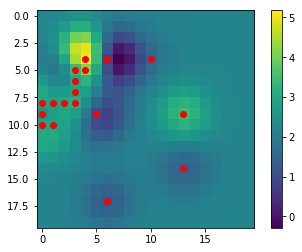

In [9]:
# Test
ok = OrdinaryKriging(to_insert['long_grid'], to_insert['lat_grid'], to_insert['PM2.5'], variogram_model='gaussian', verbose=True, enable_plotting=False)
gridx = np.arange(0.0, 20, 1)
gridy = np.arange(0.0, 20, 1)
z, ss = ok.execute('grid', gridx, gridy)
plt.imshow(z)
plt.colorbar()
plt.scatter(x=to_insert['long_grid'], y=to_insert['lat_grid'], c='r')

z[2][0]

In [10]:
def insert_into_par(par_grid, timeint, z):
    for i in range(20):
        for j in range(20):
            par_grid[i][j].partial_fit([[timeint]], [z[i][j]])

In [11]:
par_grid = [[] for i in range(20)]
for line in par_grid:
    for j in range(20):
        line.append(PassiveAggressiveRegressor(max_iter=100, random_state=0,tol=1e-3))


**Compute predictions for stationary sensors**

In [12]:
start_time = '2018-07-03 00:00:00'
end_time = '2018-07-03 00:15:00'
timeint = 0

while end_time < '2018-07-06 23:59:00':
    to_insert = all_static_data[(all_static_data['Timestamp'] > start_time) & (all_static_data['Timestamp'] < end_time)]
    to_insert = to_insert.append( mobile_sensor_data[(mobile_sensor_data['Timestamp'] > start_time) & (mobile_sensor_data['Timestamp'] < end_time)])
    to_insert = to_insert.groupby(['lat_grid','long_grid']).mean()
    to_insert.reset_index(level=to_insert.index.names, inplace=True)
    z = [[0 for j in range(20)] for i in range(20)]
    
    ok = OrdinaryKriging(to_insert['long_grid'], to_insert['lat_grid'], to_insert['PM2.5'], variogram_model='gaussian', verbose=False, enable_plotting=False)
    gridx = np.arange(0.0, 20, 1)
    gridy = np.arange(0.0, 20, 1)
    z, ss = ok.execute('grid', gridx, gridy)
    insert_into_par(par_grid, timeint, z)
    
    start_time = (datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    end_time = (datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    timeint += 1
print (timeint)

383


In [15]:
prediction_grid = [[0 for j in range(20)] for i in range(20)]
for i in range(20):
    for j in range(20):
        prediction_grid[i][j] = par_grid[i][j].predict([[383]])[0]
print(prediction_grid[3][6])


0.6647553037798947


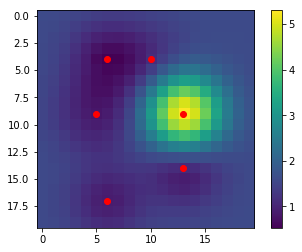

In [14]:
plt.imshow(prediction_grid)
plt.colorbar()
plt.scatter(x=[item[1] for item in gridStaticCoords.values()], y=[item[0] for item in gridStaticCoords.values()], c='r')

**Drafts**

In [195]:
prediction_grid = [[0 for j in range(20)] for i in range(20)]
for i in range(20):
    for j in range(20):
        prediction_grid[i][j] = par_grid[i][j].predict([[193]])[0]

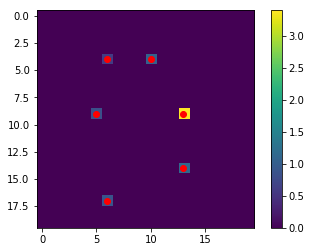

In [196]:
plt.imshow(prediction_grid)
plt.colorbar()
plt.scatter(x=[item[1] for item in gridStaticCoords.values()], y=[item[0] for item in gridStaticCoords.values()], c='r')


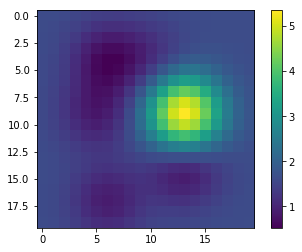

In [197]:
plt.imshow(z)
plt.colorbar()

In [17]:
static_sensor_data

[               Timestamp       PM1     PM2.5       PM10  bin0  bin1  bin2  \
 0    2018-07-03 00:04:32  1.182841  3.065754   7.579473   643    84    49   
 1    2018-07-03 00:09:32  1.282150  3.715477  11.478688   684    85    42   
 2    2018-07-03 00:14:31  1.389204  3.866031   8.551980   729    99    36   
 3    2018-07-03 00:19:31  1.298693  3.523813   7.539099   750    96    38   
 4    2018-07-03 00:24:31  1.364811  3.856071  11.496137   667   118    63   
 5    2018-07-03 00:29:31  1.947666  5.702829  20.626898   950   125    64   
 6    2018-07-03 00:34:31  1.912332  4.796910  11.292316  1125   112    68   
 7    2018-07-03 00:39:31  1.118843  2.285280   4.313570   686   112    43   
 8    2018-07-03 00:44:32  2.063003  5.490037  19.267544  1321   139    67   
 9    2018-07-03 00:49:32  1.808757  4.032448  10.992230  1159   108    63   
 10   2018-07-03 00:54:32  1.688525  4.268331  10.160081  1034   124    55   
 11   2018-07-03 00:59:32  1.417740  3.099369   4.712700   879  